# 1 – Importing Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, silhouette_score, calinski_harabasz_score, davies_bouldin_score
import scipy.cluster.hierarchy as sch
import itertools
from sklearn.decomposition import PCA

# Miscellaneous
import warnings
warnings.filterwarnings("ignore")  # Ignore warnings for clean output

# 2 – Data Acquisition & Initial Inspection

In [2]:
columns = ['Area', 'Perimeter', 'Compactness', 'Length of Kernel', 'Width of Kernel', 'Asymmetry', 'Length of Kernel Groove', 'Class']
data = pd.read_csv('/kaggle/input/seeds-dataset/seeds_dataset.txt', names=columns, sep='\s+')

In [3]:
# Check for missing values
print("Any missing values?", data.isna().any().any())

Any missing values? False


In [4]:
# Display the shape of the dataset (rows, columns)
print(f"Dataset Shape: {data.shape}")

Dataset Shape: (210, 8)


In [5]:
# Display the first 5 rows of the dataset for initial inspection
data.head()

,Area,Perimeter,Compactness,Length of Kernel,Width of Kernel,Asymmetry,Length of Kernel Groove,Class
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


In [6]:
# Display dataset information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Area                     210 non-null    float64
 1   Perimeter                210 non-null    float64
 2   Compactness              210 non-null    float64
 3   Length of Kernel         210 non-null    float64
 4   Width of Kernel          210 non-null    float64
 5   Asymmetry                210 non-null    float64
 6   Length of Kernel Groove  210 non-null    float64
 7   Class                    210 non-null    int64  
dtypes: float64(7), int64(1)
memory usage: 13.3 KB


In [7]:
# Display descriptive statistics of the dataset
data.describe().round(2)

,Area,Perimeter,Compactness,Length of Kernel,Width of Kernel,Asymmetry,Length of Kernel Groove,Class
count,210.00,210.00,210.00,210.00,210.00,210.00,210.00,210.00
mean,14.85,14.56,0.87,5.63,3.26,3.70,5.41,2.00
std,2.91,1.31,0.02,0.44,0.38,1.50,0.49,0.82
min,10.59,12.41,0.81,4.90,2.63,0.77,4.52,1.00
25%,12.27,13.45,0.86,5.26,2.94,2.56,5.04,1.00
50%,14.36,14.32,0.87,5.52,3.24,3.60,5.22,2.00
75%,17.30,15.72,0.89,5.98,3.56,4.77,5.88,3.00
max,21.18,17.25,0.92,6.68,4.03,8.46,6.55,3.00


In [8]:
# Class distribution in the dataset
data['Class'].value_counts()

Class
1    70
2    70
3    70
Name: count, dtype: int64

### Summary of Initial Inspection

- **No missing values detected** — the dataset is complete and ready for analysis.
- **Shape**: The dataset contains **210 samples** and **8 features**, plus the target class. This will be important to keep in mind before dimensionality reduction (e.g., PCA).
- **Preview**: The first few rows show clean, numerical data with consistent formatting. All features appear to be continuous variables.
- **Data Types**: All features are `float64`, except for the `Class` label which is `int64`. This confirms the dataset is numerical and suitable for techniques like PCA and clustering.
- **Descriptive Statistics**:
  - Features like **Area**, **Perimeter**, and **Length of Kernel** show a wide range of values, suggesting good variability.
  - **Compactness** has a relatively narrow spread (std ≈ 0.02), which might affect its influence in PCA.
  - **Asymmetry** has the highest standard deviation (≈ 1.50), indicating potential outliers or skew.
- **Class Distribution**: Perfectly balanced — 70 samples each for classes 1, 2, and 3. This is ideal for classification and clustering tasks.

# 3 – Exploratory Data Analysis (EDA)

## 3.1 – Pairwise Feature Scatterplot Visualization

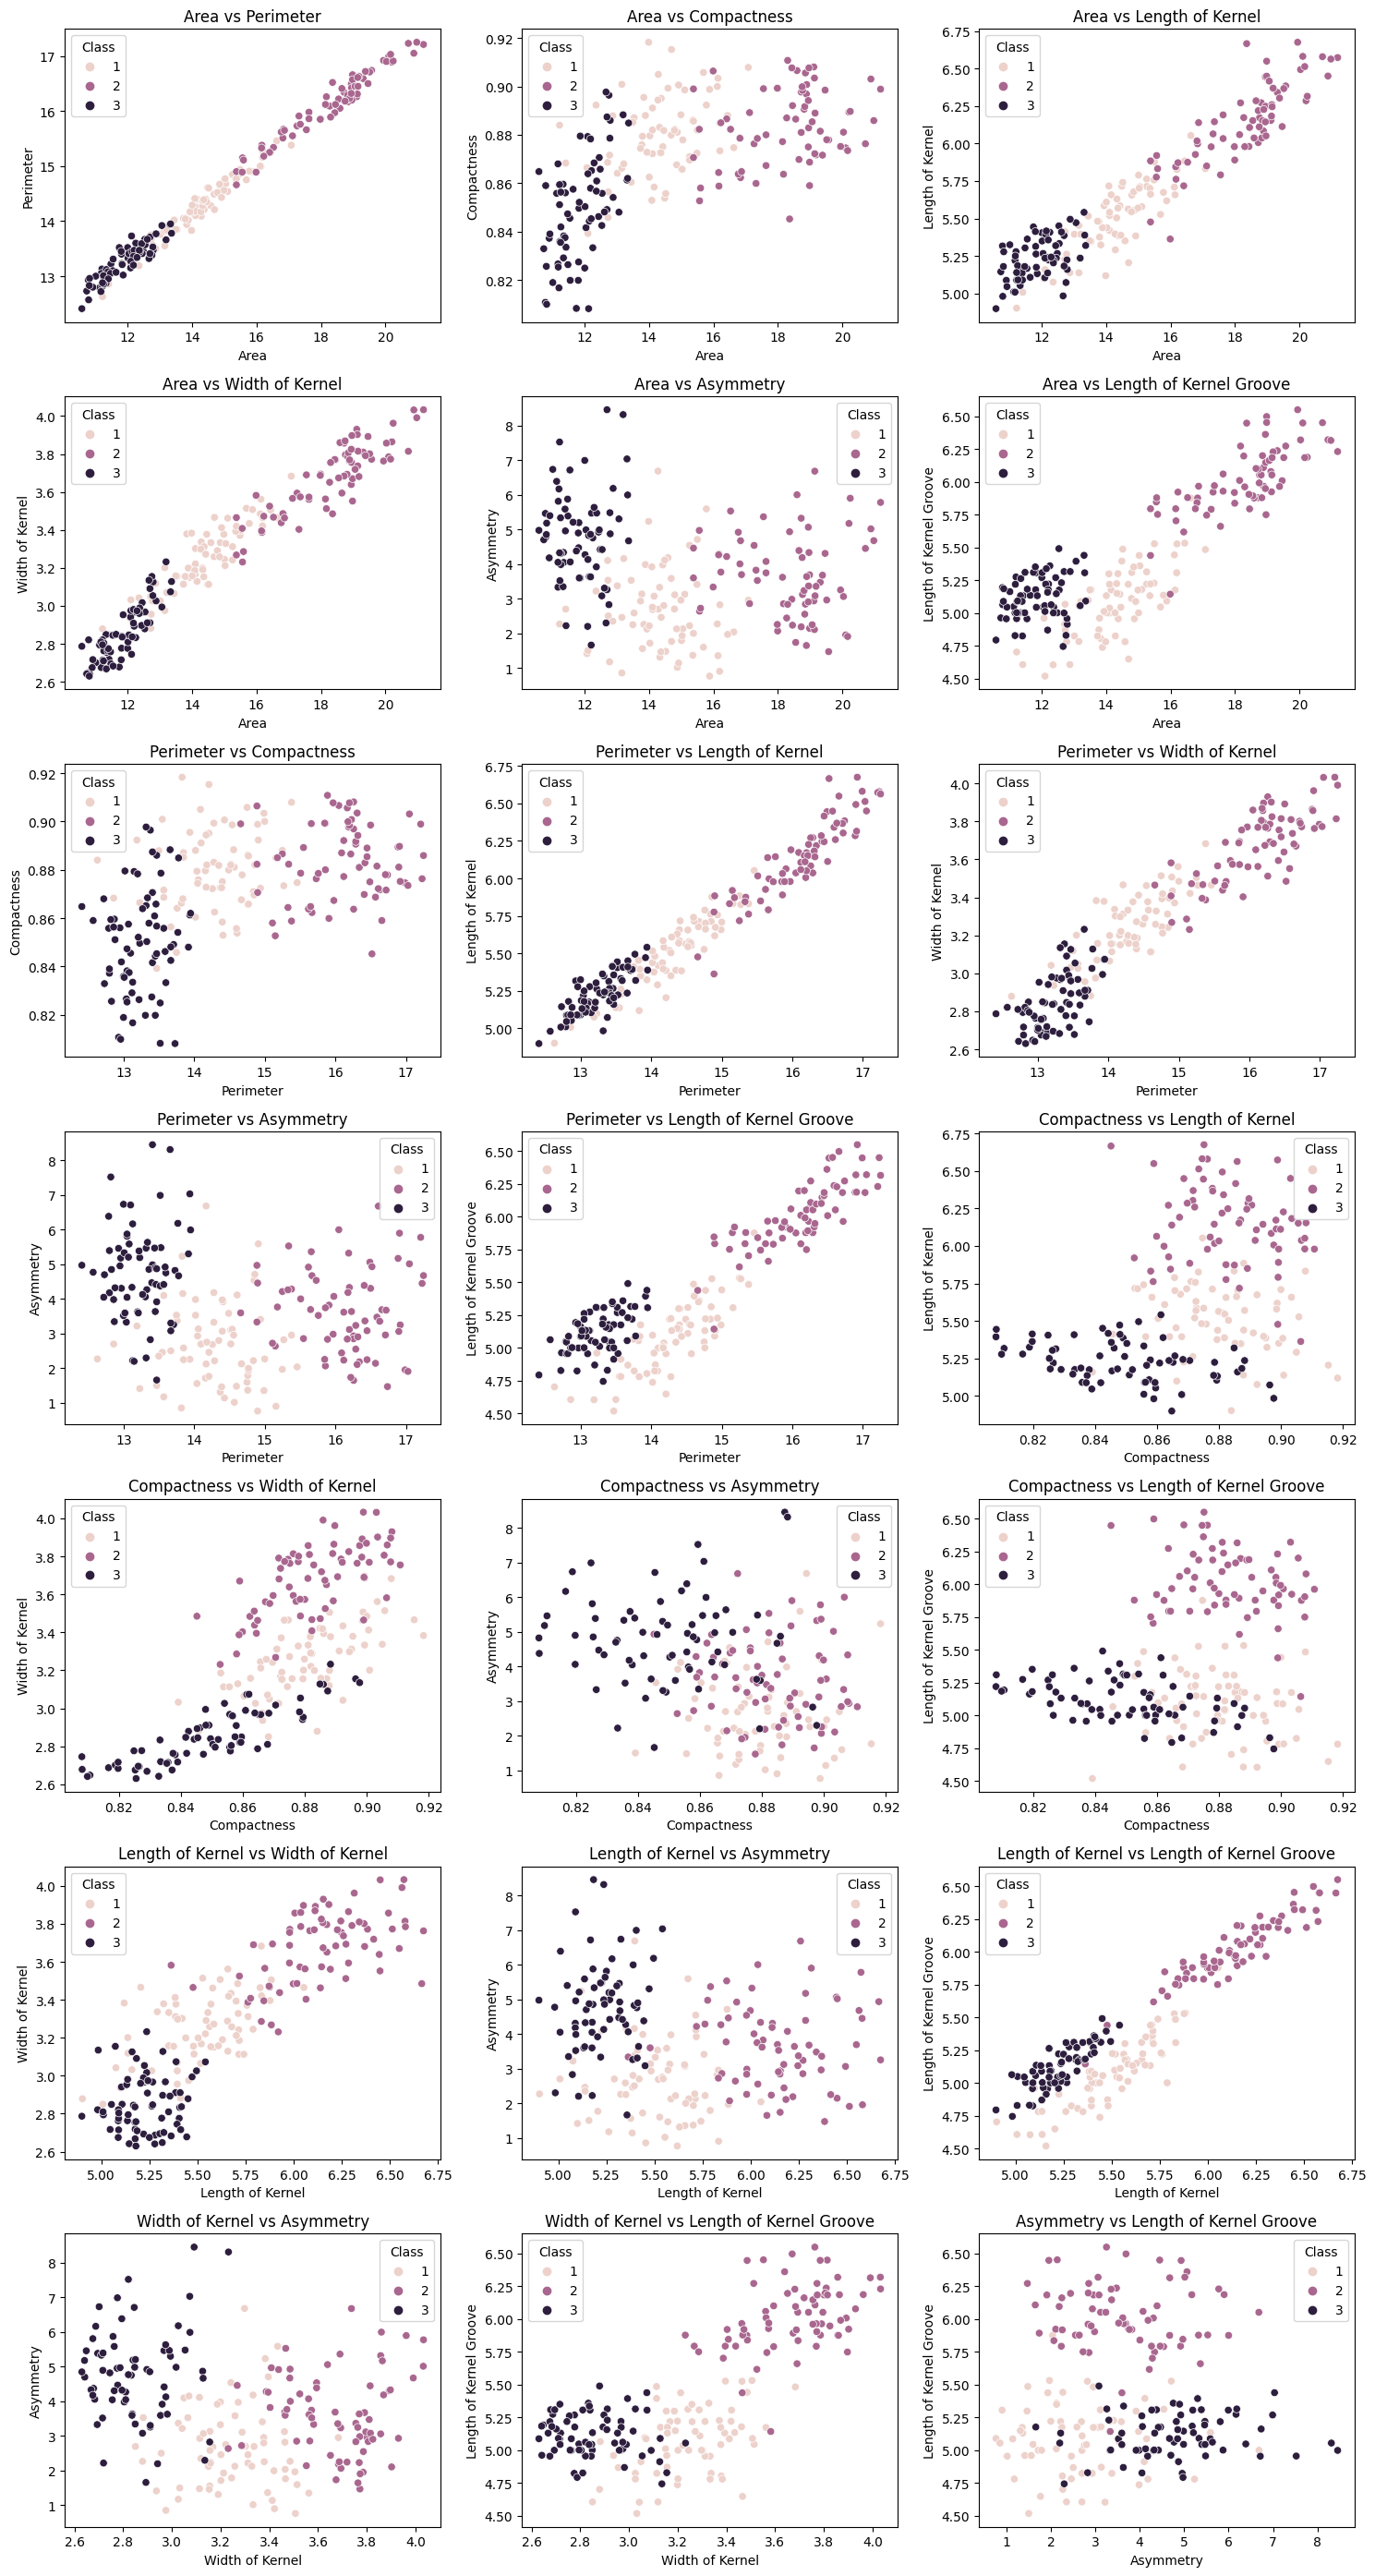

In [9]:
num_features = len(columns) - 1
combinations = list(itertools.combinations(columns[:-1], 2))

n_cols = 3  # plots per row
n_rows = (len(combinations) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
axes = axes.flatten()

for ax, (xLabel, yLabel) in zip(axes, combinations):
    sns.scatterplot(x=xLabel, y=yLabel, data=data, hue='Class', ax=ax)
    ax.set_title(f'{xLabel} vs {yLabel}')

# Remove any unused subplots
for ax in axes[len(combinations):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

## 3.2 – Full Correlation Heatmap

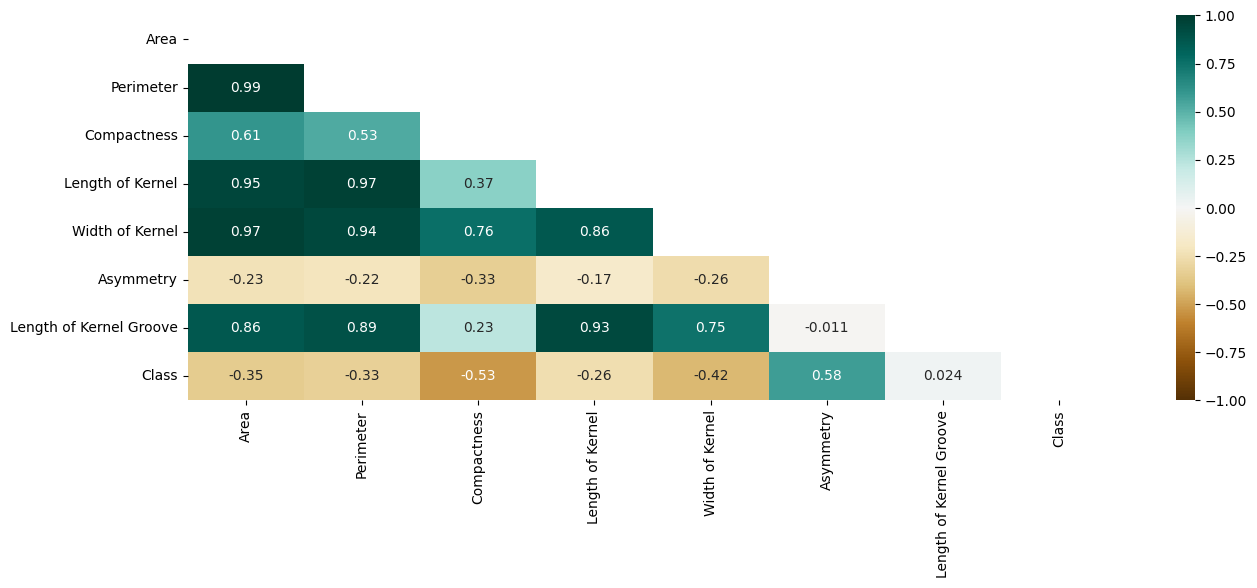

In [10]:
# Calculate the correlation matrix
corr = data.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(15, 5))

# Create the heatmap with the mask
sns.heatmap(corr, mask=mask, annot=True, cmap='BrBG', center=0, vmin=-1, vmax=1)

# Show the plot
plt.show()

### Interpretation of Correlation Matrix (for Clustering)

- **Highly correlated features**:
  - `Area`, `Perimeter`, `Length of Kernel`, and `Width of Kernel` are **strongly positively correlated** with each other (r > 0.94). These features likely capture similar geometric properties of the seeds and may introduce redundancy in clustering.
  - `Length of Kernel Groove` also shows strong correlation with `Area` (r ≈ 0.86) and `Perimeter` (r ≈ 0.89) and `Length of Kernel` (r ≈ 0.93), reinforcing the idea of overlapping information.

- **Compactness** stands out:
  - It has **moderate correlation** with `Width of Kernel` (r ≈ 0.76) but **low correlation** with most other features. This suggests it may contribute unique information to the clustering process.

- **Asymmetry** behaves differently:
  - It has **weak or negative correlations** with most features, but a **moderate positive correlation** with `Class` (r ≈ 0.58). This could make it a valuable feature for distinguishing between seed types.

- **Class correlations**:
  - `Compactness` has the **strongest negative correlation** with `Class` (r ≈ -0.53), followed by `Width of Kernel` and `Area`. These relationships hint at which features might be most influential in separating classes—useful for validating clustering results later.

- **Multicollinearity alert**:
  - The high inter-feature correlations suggest that **dimensionality reduction (e.g., PCA)** is advisable before clustering to avoid biased groupings and improve interpretability.

## 3.3 – Visualize Correlations Above Threshold (Filtered Heatmap)

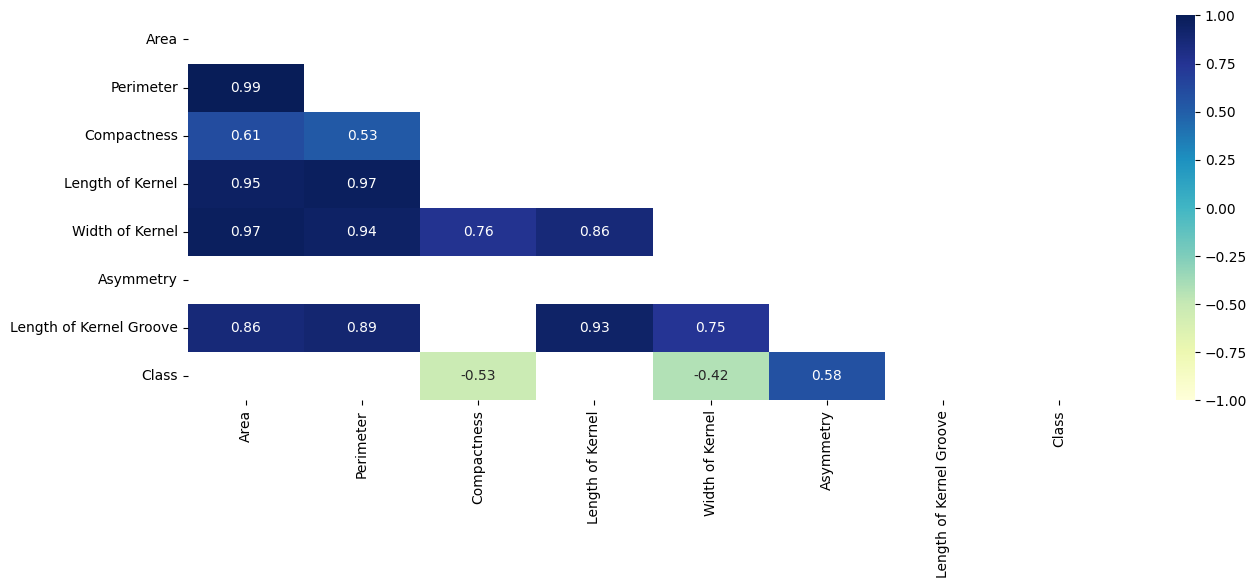

In [11]:
# Generate a mask for the upper triangle
mask_upper_triangle = np.triu(np.ones_like(corr, dtype=bool))

# Create a mask to display correlations above 0.4
mask_threshold = np.abs(corr) >= 0.4

# Combine the masks
combined_mask = mask_upper_triangle | ~mask_threshold

# Set up the matplotlib figure
plt.figure(figsize=(15, 5))

# Create the heatmap with the combined mask
sns.heatmap(corr, mask=combined_mask, annot=True, cmap='YlGnBu', center=0, vmin=-1, vmax=1)

# Show the plot
plt.show()

# 4 – Data Preprocessing

## 4.1 – Scaling

In [12]:
x = data.iloc[:, :-1].values  # Feature matrix
y_true = data['Class'].values # True labels for evaluation

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

## 4.2 – Dimensionality Reduction (PCA)

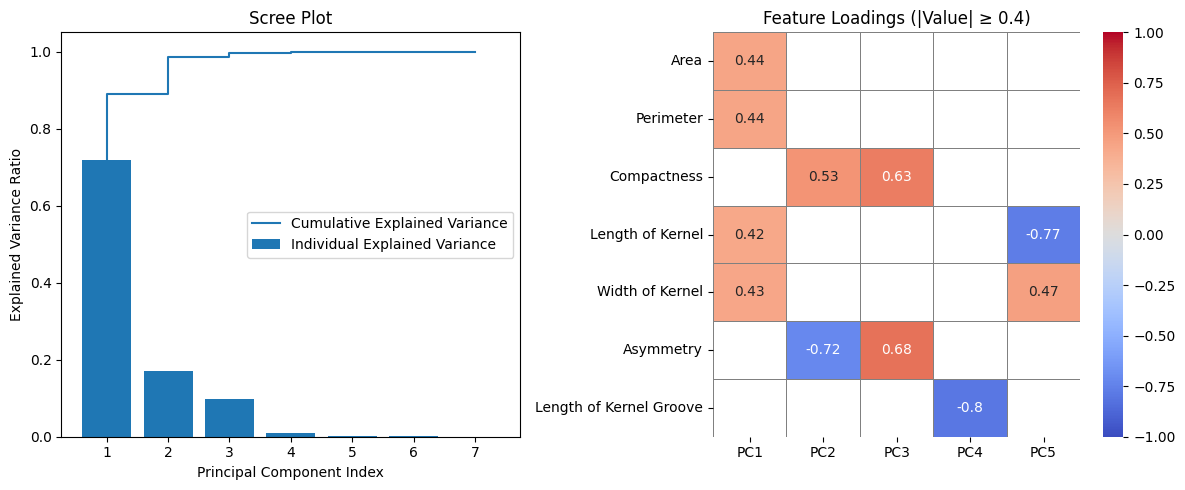

In [13]:
# Fit PCA on the scaled data
pca = PCA()
x_pca = pca.fit_transform(x_scaled)

# Calculate the cumulative explained variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot the explained variance
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.bar(
    range(1, len(explained_variance_ratio)+1),
    explained_variance_ratio,
    label='Individual Explained Variance'
)
plt.step(
    range(1, len(cumulative_variance)+1),
    cumulative_variance,
    label='Cumulative Explained Variance'
)
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Component Index')
plt.legend(loc='best')
plt.title('Scree Plot')

# Create a DataFrame for the loadings (how original features contribute to PCs)
pc_loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)],
    index=data.columns[:-1]
)

# Apply threshold: mask values with abs() < 0.4
threshold = 0.4
loadings_masked = pc_loadings.iloc[:, :5].copy()
loadings_masked = loadings_masked.where(loadings_masked.abs() >= threshold)

# Plot the heatmap
plt.subplot(1, 2, 2)
sns.heatmap(
    loadings_masked,
    annot=True,
    cmap='coolwarm',
    center=0,
    vmin=-1,
    vmax=1,
    linewidths=0.5,
    linecolor='gray'
)
plt.title('Feature Loadings (|Value| ≥ 0.4)')
plt.tight_layout()
plt.show()

### PCA Interpretation Summary

#### 1. Scree Plot (Left)

The scree plot shows how much variance each principal component (PC) captures:
- **PC1** explains ~72% of the variance — it's the dominant feature.
- **PC2** adds ~17%, and **PC3** brings the total to ~98%.

**Conclusion**: We can reduce the dataset from 7 features to 3 principal components with minimal information loss.

#### 2. Feature Loadings (Right)

The heatmap reveals how original features contribute to the first 3 PCs:
- **PC1** is strongly influenced by **Area**, **Perimeter**, **Length**, and **Width** — representing **overall size**.
- **PC2** contrasts **Compactness** (+) and **Asymmetry** (–), capturing a **shape trade-off**.
- **PC3** combines **Compactness** and **Asymmetry** positively, suggesting a **complex shape dimension**.

In [14]:
# Print individual component contributions
print("Variance Explained by Each Principal Component:")
for i, var in enumerate(explained_variance_ratio):
    print(f"PC{i+1} explains {var * 100:.2f}%")

# Print cumulative contributions
# This shows how much information (variance) is retained as we add each principal component
print("\nCumulative Variance Explained:")
for i, cum_var in enumerate(cumulative_variance):
    pcs = " + ".join([f"PC{j+1}" for j in range(i+1)])
    print(f"{pcs} = {cum_var * 100:.2f}%")

Variance Explained by Each Principal Component:
PC1 explains 71.87%
PC2 explains 17.11%
PC3 explains 9.69%
PC4 explains 0.98%
PC5 explains 0.27%
PC6 explains 0.08%
PC7 explains 0.01%

Cumulative Variance Explained:
PC1 = 71.87%
PC1 + PC2 = 88.98%
PC1 + PC2 + PC3 = 98.67%
PC1 + PC2 + PC3 + PC4 = 99.64%
PC1 + PC2 + PC3 + PC4 + PC5 = 99.91%
PC1 + PC2 + PC3 + PC4 + PC5 + PC6 = 99.99%
PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 = 100.00%


In [15]:
pca_final = PCA(n_components=0.95)  # Keep 95% of variance
x_reduced = pca_final.fit_transform(x_scaled)

print("Original Shape:", x_scaled.shape)
print("PCA Shape:", x_reduced.shape)

Original Shape: (210, 7)
PCA Shape: (210, 3)


# 5 – Cluster Validation: Determining Optimal Number of Clusters

## 5.1 – KMeans Validation: Elbow, Silhouette, Davies-Bouldin & Calinski-Harabasz

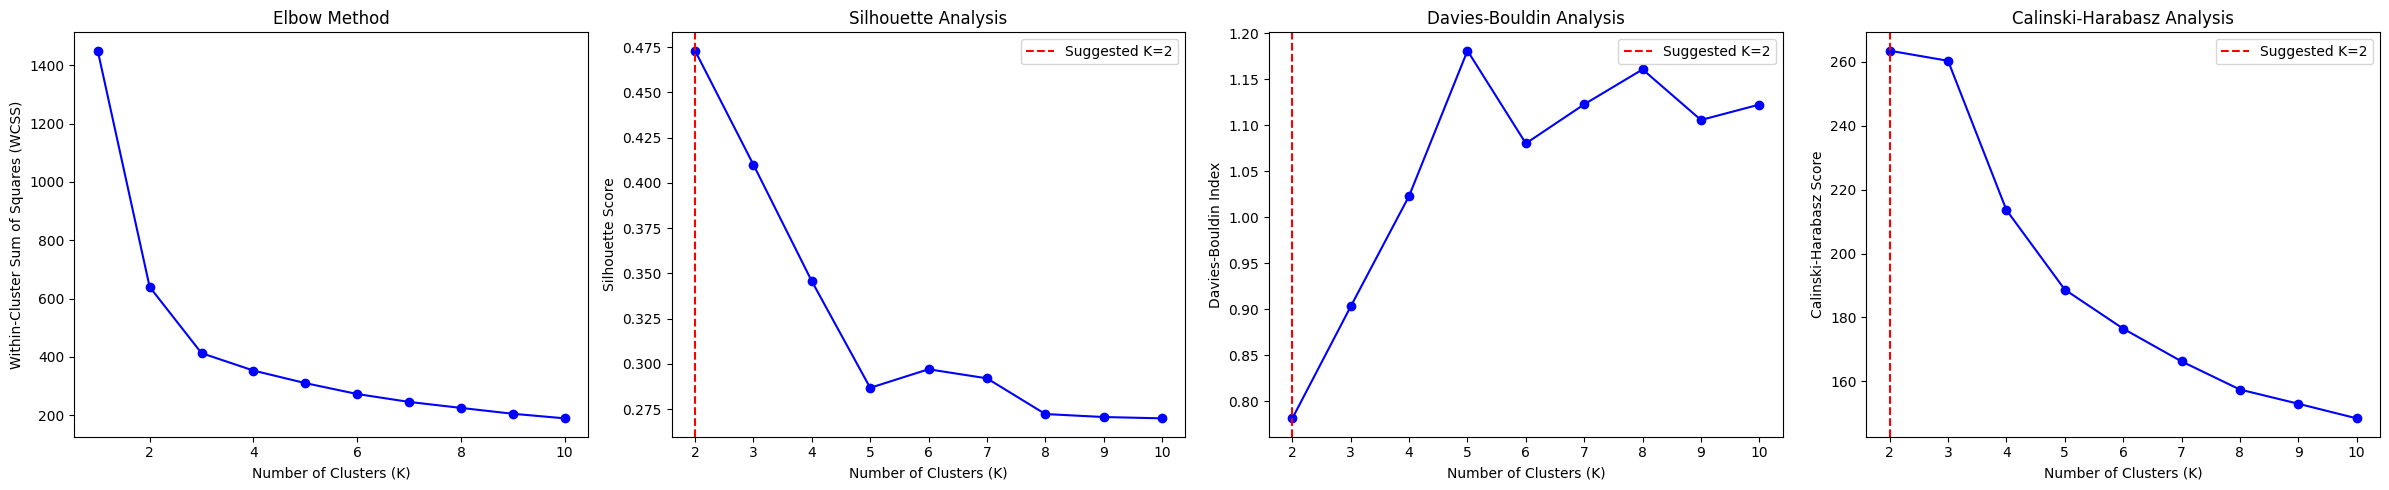

In [16]:
# Range of clusters to try
k_range = range(1, 11)

# Storage for metrics
wcss = []
sil_scores = []
db_scores = []
ch_scores = []

# Compute metrics
for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    labels = kmeans.fit_predict(x_reduced)
    wcss.append(kmeans.inertia_)
    
    if k >= 2:
        sil_scores.append(silhouette_score(x_reduced, labels))
        db_scores.append(davies_bouldin_score(x_reduced, labels))
        ch_scores.append(calinski_harabasz_score(x_reduced, labels))

# Best k values from each metric
best_k_sil = range(2, 11)[np.argmax(sil_scores)]
best_k_db  = range(2, 11)[np.argmin(db_scores)]
best_k_ch  = range(2, 11)[np.argmax(ch_scores)]

# Plotting
plt.figure(figsize=(24, 5))

# Elbow Method
plt.subplot(1, 4, 1)
plt.plot(k_range, wcss, 'bo-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method')

# Silhouette Score
plt.subplot(1, 4, 2)
plt.plot(range(2, 11), sil_scores, 'bo-')
plt.axvline(x=best_k_sil, color='r', linestyle='--', label=f'Suggested K={best_k_sil}')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.legend()

# Davies-Bouldin Index
plt.subplot(1, 4, 3)
plt.plot(range(2, 11), db_scores, 'bo-')
plt.axvline(x=best_k_db, color='r', linestyle='--', label=f'Suggested K={best_k_db}')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Analysis')
plt.legend()

# Calinski-Harabasz Score
plt.subplot(1, 4, 4)
plt.plot(range(2, 11), ch_scores, 'bo-')
plt.axvline(x=best_k_ch, color='r', linestyle='--', label=f'Suggested K={best_k_ch}')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Calinski-Harabasz Score')
plt.title('Calinski-Harabasz Analysis')
plt.legend()

plt.tight_layout()
plt.show()

## 5.2 – Hierarchical Clustering: Dendrogram Analysis

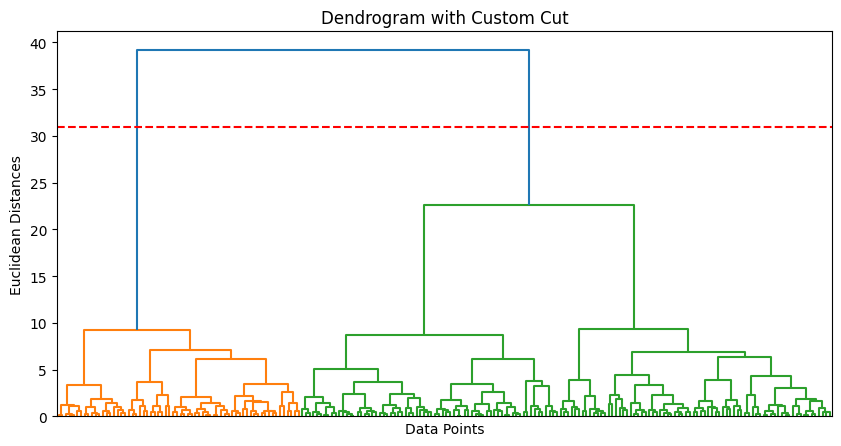

In [17]:
# Compute Linkage
linkage_matrix = sch.linkage(x_reduced, method='ward')

# Create Dendrogram and Extract Data
dendro = sch.dendrogram(linkage_matrix, no_plot=True)

# Extract the y-coordinates of horizontal lines (dcoord stores this)
horizontal_lines = sorted([y[1] for y in dendro['dcoord']])  # Extract second value (height of merge)

# Compute distances between consecutive horizontal lines
distances = np.diff(horizontal_lines)

# Find the largest gap and its midpoint
max_gap_idx = np.argmax(distances)
max_gap_value = distances[max_gap_idx]
midpoint = horizontal_lines[max_gap_idx] + max_gap_value / 2  # Halfway of the largest gap

# Plot Dendrogram Again to Draw the Cut Line
plt.figure(figsize=(10, 5))
sch.dendrogram(linkage_matrix)
plt.axhline(y=midpoint, color='red', linestyle='dashed')
plt.title('Dendrogram with Custom Cut')
plt.xlabel('Data Points')
plt.ylabel('Euclidean Distances')
plt.xticks([])  # Removes x-axis ticks
plt.show()

> **Summary – Determining Optimal Number of Clusters**
>
> To determine the optimal number of clusters, multiple validation techniques were applied:
>
> * **Internal validation metrics** including **Silhouette Score**, **Davies-Bouldin Index**, and **Calinski-Harabasz Score** all consistently suggested that **K=2** provides the best clustering structure in the reduced feature space.
> * The **Elbow Method** also leaned toward **K=2**, although there was slight ambiguity between **K=2 and K=3**.
> * **Hierarchical clustering** with dendrogram analysis supported K=2, as the largest merge gap followed the second linkage — though K=3 exhibited a similarly close gap, introducing slight ambiguity akin to the Elbow Method.
>
> However, it is important to acknowledge that this dataset originates from **three known wheat varieties** (Kama, Rosa, Canadian), suggesting an expected cluster count of **K=3**.
>
> Therefore, for comprehensive insight, clustering will be performed with **both K=2 and K=3**:
>
> * **K=2**: Reflects the natural structure discovered from unsupervised analysis.
> * **K=3**: Aligns with prior domain knowledge and the true number of classes.
>
> This dual approach ensures both **data-driven clustering** and **domain-consistent modeling**, allowing further evaluation of clustering performance against the original class labels using external validation metrics (e.g., ARI).

# 6 – Clustering Results & Interpretation

## 6.1 – KMeans Clustering with K=2 (Initial Projection)

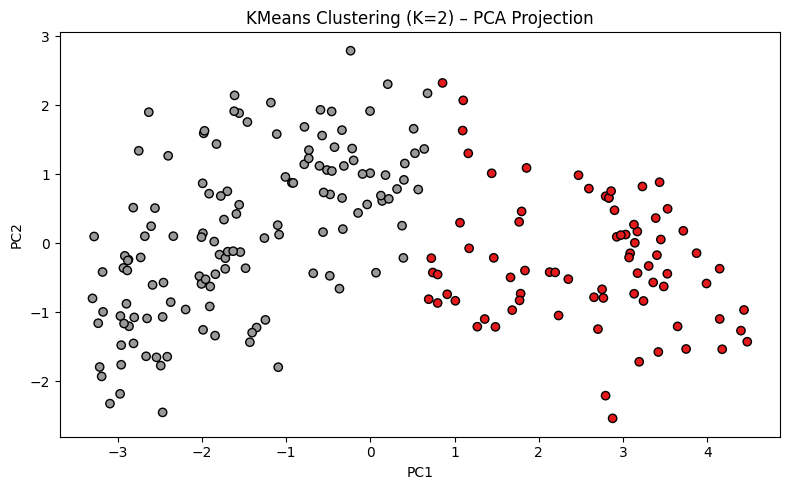

In [18]:
# Apply KMeans with K=2
kmeans_k2 = KMeans(n_clusters=2, init='k-means++', n_init=10, random_state=42)
cluster_labels_k2 = kmeans_k2.fit_predict(x_reduced)

# Visualize clusters using PCA
plt.figure(figsize=(8, 5))
plt.scatter(
    x_reduced[:, 0],
    x_reduced[:, 1],
    c=cluster_labels_k2,
    cmap='Set1',
    edgecolor='k'
)
plt.title('KMeans Clustering (K=2) – PCA Projection')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.show()

## 6.2 – Model Comparison: KMeans vs Hierarchical (K=3)

In [19]:
n_clusters = 3
models = {
    'K-Means': KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, random_state=42),
    'Hierarchical': AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
}

for model_name, model in models.items():
    # Train and predict
    y_pred = model.fit_predict(x_reduced)

    # External validation using ARI (since ground truth is known)
    ari = adjusted_rand_score(y_true, y_pred)

    # Display ARI score
    print(f'{model_name:<12} → ARI: {ari:.4f}  ({ari*100:.2f}%)')

K-Means      → ARI: 0.7850  (78.50%)
Hierarchical → ARI: 0.7844  (78.44%)


### Clustering Evaluation Summary

We applied two clustering algorithms — **K-Means** and **Agglomerative Hierarchical Clustering** — to the reduced feature space (`x_reduced`) and evaluated their performance using the **Adjusted Rand Index (ARI)**, which compares predicted cluster labels to the known ground truth (`y_true`).

| Model         | ARI Score | Interpretation         |
|---------------|-----------|------------------------|
| K-Means       | 0.7850    | 78.50% Similarity      |
| Hierarchical  | 0.7844    | 78.44% Similarity      |

Both models performed **almost identically**, with **K-Means** slightly outperforming Hierarchical Clustering by **0.06%**. Given the minimal difference, either model is valid. However, **K-Means is preferred** due to:

- Slightly higher ARI
- Better scalability to large datasets
- Simpler interpretation and tuning

> Note: The number of clusters (`n_clusters = 3`) was chosen based on prior domain knowledge.

## 6.3 – Final Visualization: KMeans Clustering (K=3) in PCA Space

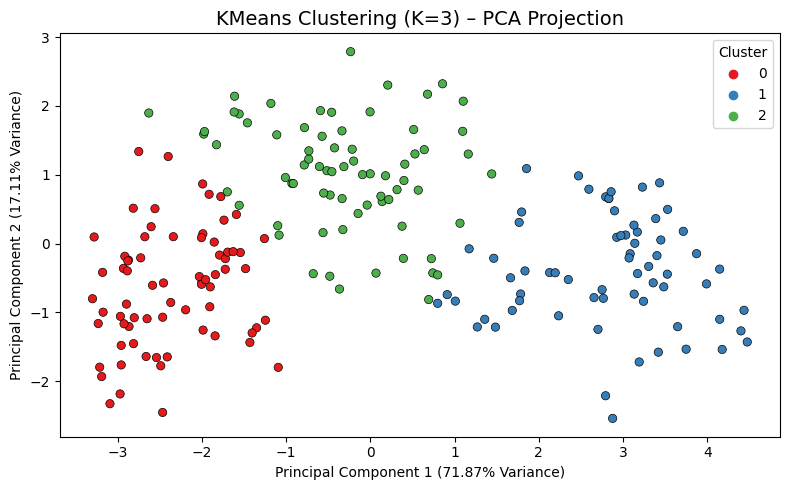

In [20]:
# Convert first 2 PCA components to DataFrame
pca_df = pd.DataFrame(x_reduced[:, :2], columns=['PC1', 'PC2'])

# Add KMeans labels
pca_df['KMeans Cluster'] = models['K-Means'].labels_

# Plot
plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=pca_df,
    x='PC1', y='PC2',
    hue='KMeans Cluster',
    palette='Set1',
    edgecolor='k',
)
plt.title('KMeans Clustering (K=3) – PCA Projection', fontsize=14)
plt.xlabel(f'Principal Component 1 ({explained_variance_ratio[0]:.2%} Variance)')
plt.ylabel(f'Principal Component 2 ({explained_variance_ratio[1]:.2%} Variance)')
plt.legend(title='Cluster', loc='best')
plt.tight_layout()
plt.show()